### Import
For Load Data Section

In [1]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Load Data

To develop a generalizable architecture for fault diagnosis, we utilize two benchmark datasets: **KAIST** and **CWRU**.

- **KAIST Dataset:** The Korea Advanced Institute of Science & Technology (KAIST) dataset contains vibration signals from rotating machinery under various fault types, motor loads, and fault severities. It provides a diverse set of conditions, making it suitable for robust model training and evaluation.

- **CWRU Dataset:** The Case Western Reserve University (CWRU) bearing dataset is widely used for bearing fault diagnosis research. It includes vibration data collected under different fault types, locations, and loads.

By training the ML model on both KAIST and CWRU datasets, we aim to demonstrate its ability to generalize across different machines, fault types, and operating conditions.

## KAIST Dataset

The KAIST Dataset (Jung2022) has 4 sensed variables: acoustic, current, temperature, and vibration. In this case, only vibration will be used.
- **Machine Conditions (Normal, BPFI, BPFO, Misalign, and Unbalance):** Fault types and normal operating condition
- **Motor load (0Nm, 2Nm, 4Nm):** Torque applied to the motor simulating load
- **Fault Severity:** Depending on the type of fault there are at least 3 severities. For example BPFI has a fault severity represented in the crack width (0.3mm, 1mm, 3mm)

In [2]:
# ------------------------------ KAIST Dataset ------------------------------
# Paths and parameters
vibration_mat_folder_kaist = '../../data/raw_kaist/vibration_mat_25.6kHz'
v_length_kaist = 1536000  # length of the smaller vector in the dataset
sampling_rate_kaist = 25600  # fixed at 25.6 kHz

# Class labels for different domains
class_labels_kaist0 = ['0Nm_Normal', '0Nm_BPFI_03', '0Nm_BPFO_03', '0Nm_Misalign_01', '0Nm_Unbalance_0583mg']
#class_labels_kaist1 = ['2Nm_Normal', '2Nm_BPFI_03', '2Nm_BPFO_03', '2Nm_Misalign_01', '2Nm_Unbalance_0583mg']
#class_labels_kaist2 = ['4Nm_Normal', '4Nm_BPFI_03', '4Nm_BPFO_03', '4Nm_Misalign_01', '4Nm_Unbalance_0583mg']

def load_domain_data_kaist(class_labels, domain_name):
    """Load vibration data for a domain, using CSV cache if available. No fixed length trim."""
    vibration_data = {}
    folder_path = f'../../data/flex-data/kaist_csv/vibration{sampling_rate_kaist/1000}kHz_domain{domain_name}'
    os.makedirs(folder_path, exist_ok=True)

    print(f"Loading domain {domain_name}...")
    for label in class_labels:
        csv_path = f'{folder_path}/{label}.csv'
        mat_path = os.path.join(vibration_mat_folder_kaist, f"{label}.mat")

        if os.path.exists(csv_path):
            print(f"  Loading {label} from CSV...")
            vibration_data[label] = pd.read_csv(csv_path).values.astype(np.float32)
            continue

        if os.path.exists(mat_path):
            print(f"  Loading {label} from .mat file...")
            m = sio.loadmat(mat_path)
            # keep full available length and all columns
            vibration = m['Signal']['y_values'][0][0][0][0][0].astype(np.float32)
            vibration_data[label] = vibration

            print(f"  Saving {label} to CSV...")
            pd.DataFrame(vibration).to_csv(csv_path, index=False)
        else:
            print(f"  Warning: {label} not found")

    print(f"Domain {domain_name} loaded: {len(vibration_data)} classes")
    return vibration_data

# Load all domains
vibration_data_kaist0 = load_domain_data_kaist(class_labels_kaist0, '0Nm')
#vibration_data_kaist1 = load_domain_data_kaist(class_labels_kaist1, '2Nm')
#vibration_data_kaist2 = load_domain_data_kaist(class_labels_kaist2, '4Nm')

#vibration_data_kaist = {**vibration_data_kaist0, **vibration_data_kaist1, **vibration_data_kaist2}
vibration_data_kaist = {**vibration_data_kaist0}
class_labels_kaist = list(vibration_data_kaist.keys())


Loading domain 0Nm...
  Loading 0Nm_Normal from CSV...
  Loading 0Nm_BPFI_03 from CSV...
  Loading 0Nm_BPFO_03 from CSV...
  Loading 0Nm_Misalign_01 from CSV...
  Loading 0Nm_Unbalance_0583mg from CSV...
Domain 0Nm loaded: 5 classes


### Plot Random KAIST signal

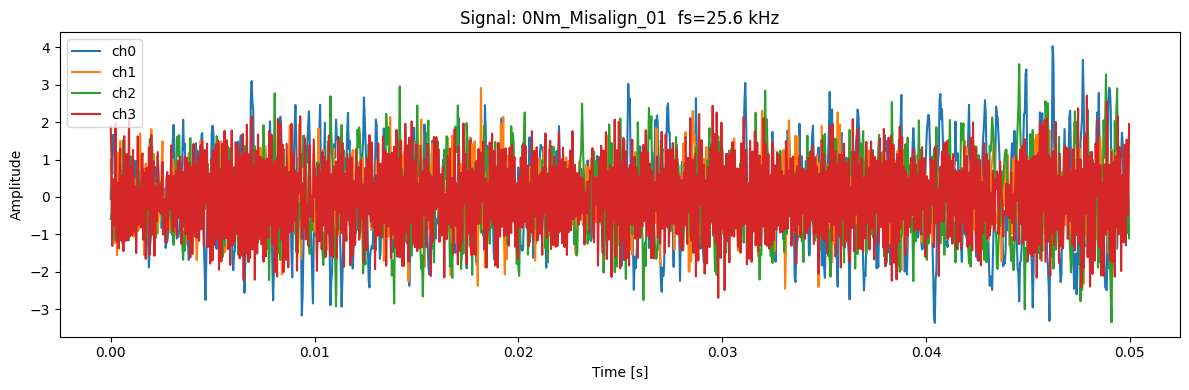

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_signal(data_dict, fs, seconds=0.1, channels=None, label=None, title_prefix="Signal"):
    """
    Plot a short time span from a selected or random signal.
    
    Parameters
    ----------
    data_dict : dict[label] -> np.ndarray [samples, channels]
        Dictionary of signals.
    fs : int
        Sampling rate in Hz.
    seconds : float
        Duration of the plotted segment in seconds.
    channels : list[int] or None
        Which channels to plot (0-based). None means all.
    label : str or None
        If provided, plot this class label; if None, pick randomly.
    title_prefix : str
        Title prefix for the plot.
    """
    if not data_dict:
        raise ValueError("data_dict is empty")

    # Choose label
    if label is None:
        label = random.choice(list(data_dict.keys()))
    elif label not in data_dict:
        raise ValueError(f"Label '{label}' not found. Available: {list(data_dict.keys())[:5]}...")

    x = data_dict[label]
    if x.ndim == 1:
        x = x[:, None]

    n_show = min(int(seconds * fs), x.shape[0])
    if n_show < 1:
        raise ValueError("seconds too small for given fs")

    if channels is None:
        ch_idx = range(x.shape[1])
    else:
        ch_idx = [c for c in channels if 0 <= c < x.shape[1]]

    t = np.arange(n_show) / fs

    plt.figure(figsize=(12, 4))
    for c in ch_idx:
        plt.plot(t, x[:n_show, c], label=f"ch{c}")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(f"{title_prefix}: {label}  fs={fs/1000:.1f} kHz")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Usage
# KAIST at 25.6 kHz
plot_signal(vibration_data_kaist, fs=sampling_rate_kaist, seconds=0.05)
# plot_signal(vibration_data_kaist, fs=sampling_rate_kaist, seconds=0.05, label='0Nm_Normal', channels=[0])



## CWRU Dataset

The Case Western Reserve University (CWRU) Bearing Dataset provides vibration measurements collected from a motor test rig with seeded bearing faults. Acceleration data was captured near the motor bearings under varying load and fault conditions.

- **Machine Conditions (Normal, Inner Race, Outer Race, and Ball Faults):** Single-point faults were introduced using electro-discharge machining (EDM) at the inner race, outer race, or rolling element. Normal operating condition data is also included.  
- **Motor Load (0–3 hp):** Torque loads applied to the 2 hp Reliance Electric motor, corresponding to operating speeds between 1720 and 1797 RPM.  
- **Fault Severity:** Fault diameters of 0.007, 0.014, 0.021, 0.028, and 0.040 inches were tested. SKF bearings were used for smaller faults (7–21 mils) and NTN bearings for larger faults (28–40 mils).  
- **Sensor Setup:** Vibration was recorded using accelerometers placed at the 12 o’clock position of the drive end and fan end bearings. Additional measurements were taken at the base plate in some experiments.  
- **Sampling Rate:** Signals were collected at 12 kHz for most cases, with 48 kHz recordings available for drive end bearing faults.  


In [4]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import resample_poly

# ------------------------------ CWRU Dataset ------------------------------
# Paths and parameters
# Keep your original folder. The code will resample whatever it loads.
vibration_mat_folder_cwru = '../../data/raw_cwru/vibration_mat_12kHz'  # or .../vibration_mat_12kHz if that is your source
v_length_cwru = 260868  # length to trim before resampling if needed
sampling_rate_cwru = 12000
target_sampling_rate_cwru = 25600  # target sampling rate for resampling

# Integer ratio for exact 12 kHz -> 25.6 kHz conversion
UPSAMPLE = 32
DOWNSAMPLE = 15
assert abs(target_sampling_rate_cwru * DOWNSAMPLE - sampling_rate_cwru * UPSAMPLE) == 0, "Sampling rates must match 32 over 15 ratio"

# Class labels for different domains
class_labels_cwru0 = ['B007_0', 'IR007_0', 'Normal_0', 'OR007@3_0', 'OR007@6_0', 'OR007@12_0']
#class_labels_cwru1 = ['B007_1', 'IR007_1', 'Normal_1', 'OR007@3_1', 'OR007@6_1', 'OR007@12_1']
#class_labels_cwru2 = ['B007_2', 'IR007_2', 'Normal_2', 'OR007@3_2', 'OR007@6_2', 'OR007@12_2']

def _load_mat_signal(mat_path, max_len=None, channels=("DE", "FE", "BA")):
    """
    Load CWRU vibration from .mat and return a 2D array [time, channels].
    Channels are taken in order DE, FE, BA if present.
    Ignores the *RPM scalar.
    """
    m = sio.loadmat(mat_path)

    # Collect available channels by suffix pattern *_<CH>_time
    series = []
    lengths = []
    for ch in channels:
        # Find the key that ends with _<CH>_time, e.g., X118_DE_time
        key = next((k for k in m.keys() if not k.startswith('__') and k.endswith(f"_{ch}_time")), None)
        if key is not None:
            arr = np.asarray(m[key]).squeeze()
            if arr.ndim != 1:
                arr = arr.reshape(-1)
            series.append(arr)
            lengths.append(arr.shape[0])

    if not series:
        raise ValueError(f"No DE FE BA time series found in {mat_path}")

    # Use the shortest available length to align channels
    n = min(lengths)
    if max_len is not None:
        n = min(n, int(max_len))

    # Stack as columns in the requested channel order
    stacked = np.stack([s[:n] for s in series], axis=1).astype(np.float32, copy=False)
    return stacked



def _resample_to_target(x_2d, up=UPSAMPLE, down=DOWNSAMPLE):
    """Resample along the time axis keeping channels in columns."""
    # x_2d shape: [time, channels]
    y = resample_poly(x_2d, up, down, axis=0)
    return y.astype(np.float32, copy=False)


def load_domain_data_cwru(class_labels, domain_name):
    """Load and resample vibration data to the target rate, using CSV cache if available."""
    vibration_data = {}

    # Cache directory is tied to the target sampling rate
    folder_path = f'../../data/flex-data/cwru_csv/vibration{target_sampling_rate_cwru/1000}kHz_domain{domain_name}'
    os.makedirs(folder_path, exist_ok=True)

    print(f"Loading domain {domain_name} at {target_sampling_rate_cwru} Hz...")

    for label in class_labels:
        csv_path = f'{folder_path}/{label}.csv'
        mat_path = os.path.join(vibration_mat_folder_cwru, f"{label}.mat")

        if os.path.exists(csv_path):
            print(f"  Loading {label} from resampled CSV cache...")
            vibration_data[label] = pd.read_csv(csv_path).values
            continue

        if os.path.exists(mat_path):
            print(f"  Loading {label} from .mat file and resampling...")
            x = _load_mat_signal(mat_path, max_len=v_length_cwru)
            y = _resample_to_target(x, UPSAMPLE, DOWNSAMPLE)

            # Optional deterministic length control from source trimming
            # Expected resampled length based on v_length_cwru
            # expected_len = int(round(v_length_cwru * target_sampling_rate_cwru / sampling_rate_cwru))
            # if y.shape[0] != expected_len:
            #     # Trim or pad to expected length if you need strict alignment across classes
            #     if y.shape[0] > expected_len:
            #         y = y[:expected_len, :]
            #     else:
            #         pad = np.zeros((expected_len - y.shape[0], y.shape[1]), dtype=y.dtype)
            #         y = np.vstack([y, pad])

            vibration_data[label] = y

            print(f"  Saving {label} resampled CSV...")
            pd.DataFrame(y).to_csv(csv_path, index=False)
        else:
            print(f"  Warning: {label} not found in cache or mats")

    print(f"Domain {domain_name} loaded: {len(vibration_data)} classes at {target_sampling_rate_cwru} Hz")
    return vibration_data


# Load all domains already resampled to 25.6 kHz
vibration_data_cwru0 = load_domain_data_cwru(class_labels_cwru0, '0HP')
#vibration_data_cwru1 = load_domain_data_cwru(class_labels_cwru1, '1HP')
#vibration_data_cwru2 = load_domain_data_cwru(class_labels_cwru2, '2HP')

#vibration_data_cwru = {**vibration_data_cwru0, **vibration_data_cwru1, **vibration_data_cwru2}
vibration_data_cwru = {**vibration_data_cwru0,}
class_labels_cwru = list(vibration_data_cwru.keys())


Loading domain 0HP at 25600 Hz...
  Loading B007_0 from resampled CSV cache...
  Loading IR007_0 from resampled CSV cache...
  Loading Normal_0 from resampled CSV cache...
  Loading OR007@3_0 from resampled CSV cache...
  Loading OR007@6_0 from resampled CSV cache...
  Loading OR007@12_0 from resampled CSV cache...
Domain 0HP loaded: 6 classes at 25600 Hz


Plot Random signal CWRU

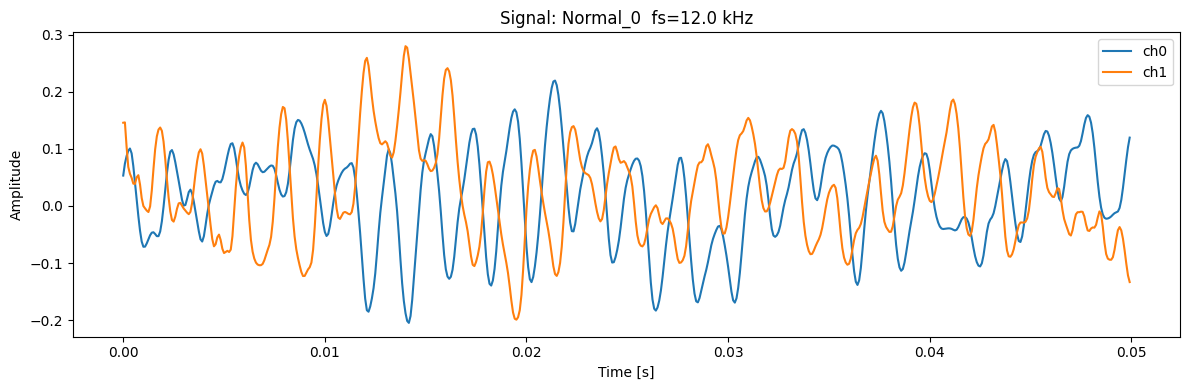

In [5]:
# CWRU after your resampling step at 25.6 kHz
# plot_signal(vibration_data_cwru, fs=target_sampling_rate_cwru, seconds=0.05)
plot_signal(vibration_data_cwru, fs=sampling_rate_cwru, seconds=0.05, label='Normal_0')

### Resampling visualization CWRU Dataset

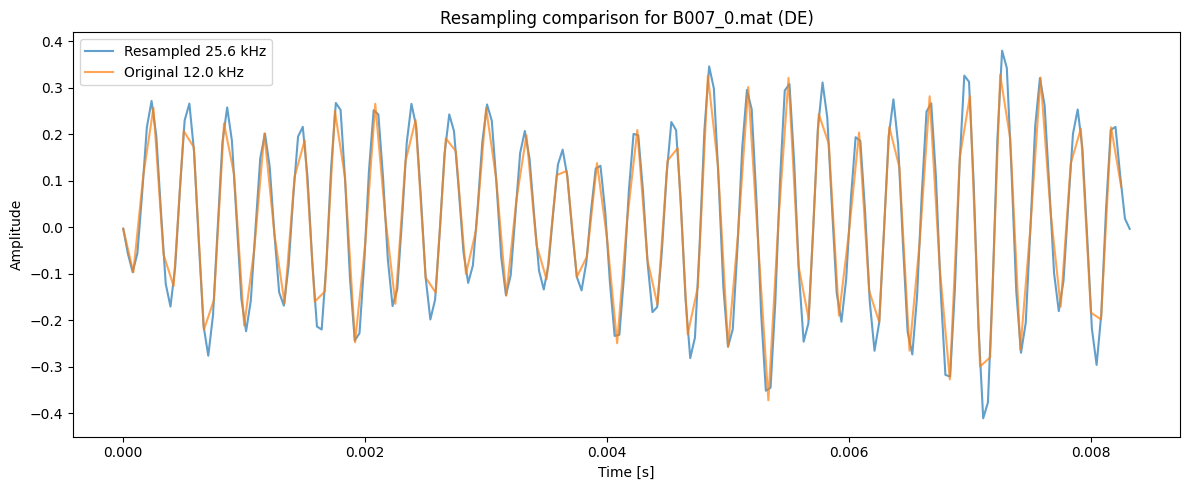

In [6]:
def compare_resampling(mat_path, channel="DE", max_len=6000):
    """
    Plot a short segment of the original and resampled signals
    from a given CWRU .mat file.
    """
    # Load raw signal at 12 kHz
    x = _load_mat_signal(mat_path, max_len=max_len, channels=(channel,))
    # Resample to 25.6 kHz
    y = _resample_to_target(x, UPSAMPLE, DOWNSAMPLE)

    # Time axes
    t_orig = np.arange(x.shape[0]) / sampling_rate_cwru
    t_resampled = np.arange(y.shape[0]) / target_sampling_rate_cwru

    plt.figure(figsize=(12, 5))
    plt.plot(t_resampled, y[:,0], label=f"Resampled {target_sampling_rate_cwru/1000:.1f} kHz", alpha=0.7)
    plt.plot(t_orig, x[:,0], label=f"Original {sampling_rate_cwru/1000:.1f} kHz", alpha=0.7)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(f"Resampling comparison for {os.path.basename(mat_path)} ({channel})")
    plt.legend()
    plt.tight_layout()
    plt.show()

mat_path = "../../data/raw_cwru/vibration_mat_12kHz/B007_0.mat"
compare_resampling(mat_path, channel="DE", max_len=100)

# Feature Extraction

In [7]:
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft

def extract_features_dataset(
    data_dict,
    class_labels,
    window_size,
    stride=None,
    hilbert_channels=(0, 3),
    fixed_channels=None,
    auto_common=True
):
    """
    Returns:
      X: [segments, window_size//2, C] with consistent C across all samples
      y: [segments] integer class ids aligned to class_labels
      used_channels: list of channel indices used in X
      seg_meta: list of dicts with label and segment info
    """
    if stride is None:
        stride = window_size

    # Decide consistent channels
    if fixed_channels is not None:
        used_channels = list(fixed_channels)
    elif auto_common:
        # Use the minimum channel count across available arrays
        ch_counts = []
        for lbl in class_labels:
            if lbl in data_dict:
                arr = data_dict[lbl]
                if arr.ndim == 1:
                    arr = arr[:, None]
                ch_counts.append(arr.shape[1])
        if not ch_counts:
            raise ValueError("No arrays found for the provided class_labels")
        min_c = int(min(ch_counts))
        if min_c < 1:
            raise ValueError("Detected zero channels")
        used_channels = list(range(min_c))
    else:
        # Default to the first array shape
        first_lbl = next(lbl for lbl in class_labels if lbl in data_dict)
        first_arr = data_dict[first_lbl]
        if first_arr.ndim == 1:
            first_arr = first_arr[:, None]
        used_channels = list(range(first_arr.shape[1]))

    feats = []
    y_list = []
    seg_meta = []

    for cls_id, lbl in enumerate(class_labels):
        if lbl not in data_dict:
            continue
        arr = data_dict[lbl]
        if arr.ndim == 1:
            arr = arr[:, None]

        # If any requested channel is out of range, skip this label entirely
        if any(ch >= arr.shape[1] for ch in used_channels):
            # skip arrays lacking required channels
            continue

        x = arr[:, used_channels]  # enforce consistent channels
        n, c = x.shape
        if n < window_size:
            continue

        starts = np.arange(0, n - window_size + 1, stride, dtype=int)
        for s in starts:
            seg = x[s:s + window_size, :]  # [win, C]

            # Z score per channel
            mu = seg.mean(axis=0, keepdims=True)
            sd = seg.std(axis=0, keepdims=True)
            sd = np.where(sd == 0, 1e-8, sd)
            seg_z = (seg - mu) / sd

            # Hilbert envelope on selected channels if they exist
            seg_proc = seg_z.copy()
            for hch in hilbert_channels:
                if 0 <= hch < seg_proc.shape[1]:
                    seg_proc[:, hch] = np.abs(hilbert(seg_proc[:, hch]))

            # FFT magnitude positive half per channel
            spec = np.abs(fft(seg_proc, axis=0))[:window_size // 2, :]  # [bins, C]
            feats.append(spec.astype(np.float32))
            y_list.append(cls_id)
            seg_meta.append({
                "label": lbl,
                "start": int(s),
                "end": int(s + window_size),
                "channels_used": used_channels
            })

    if not feats:
        raise ValueError("No segments extracted. Check window_size, stride, and channels policy.")

    X = np.stack(feats, axis=0)  # [Nseg, bins, C] now consistent
    y = np.array(y_list, dtype=np.int64)
    return X, y, used_channels, seg_meta


# KAIST
X_kaist, y_kaist, ch_kaist, meta_kaist = extract_features_dataset(
    vibration_data_kaist, class_labels_kaist,
    window_size=5120, stride=5120, fixed_channels=[0]
)

# CWRU at 25.6 kHz after your resampling
X_cwru, y_cwru, ch_cwru, meta_cwru = extract_features_dataset(
    vibration_data_cwru, class_labels_cwru,
    window_size=5120, stride=5120, fixed_channels=[0]
)



Summarize Features


[KAIST] Summary
  Shape X: (3300, 2560, 1)  y: (3300,)
  Channels: 1  Bins: 2560
  Stats  min:0.003  max:6521.695  mean:31.916
  NaN present: False  Inf present: False
  Samples per class:
   - 0Nm_Normal: 1500
   - 0Nm_BPFI_03: 300
   - 0Nm_BPFO_03: 300
   - 0Nm_Misalign_01: 600
   - 0Nm_Unbalance_0583mg: 600
  Mean spectral energy per channel: [45748676.]


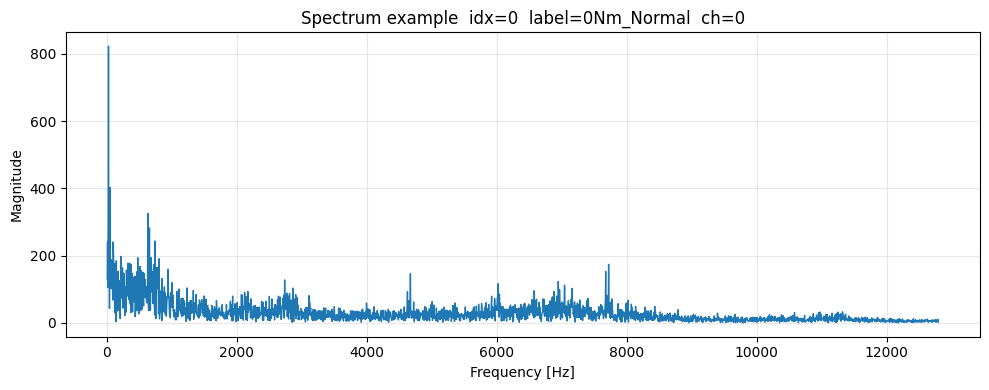

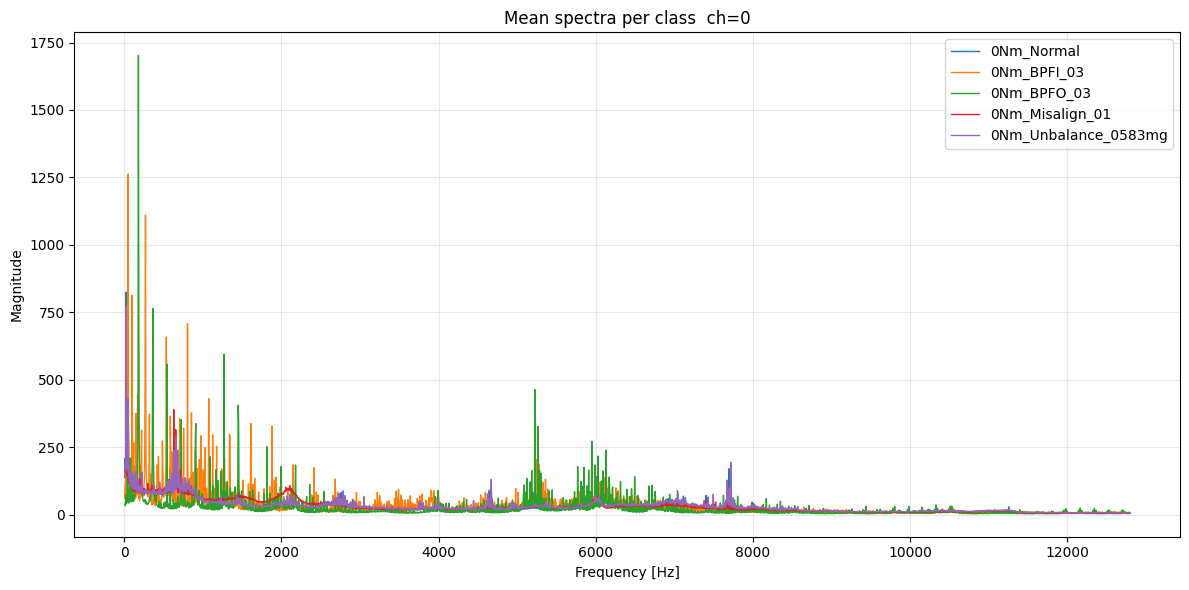


[CWRU] Summary
  Shape X: (352, 2560, 1)  y: (352,)
  Channels: 1  Bins: 2560
  Stats  min:0.001  max:6602.408  mean:18.552
  NaN present: False  Inf present: False
  Samples per class:
   - B007_0: 51
   - IR007_0: 50
   - Normal_0: 101
   - OR007@3_0: 50
   - OR007@6_0: 50
   - OR007@12_0: 50
  Mean spectral energy per channel: [44044076.]


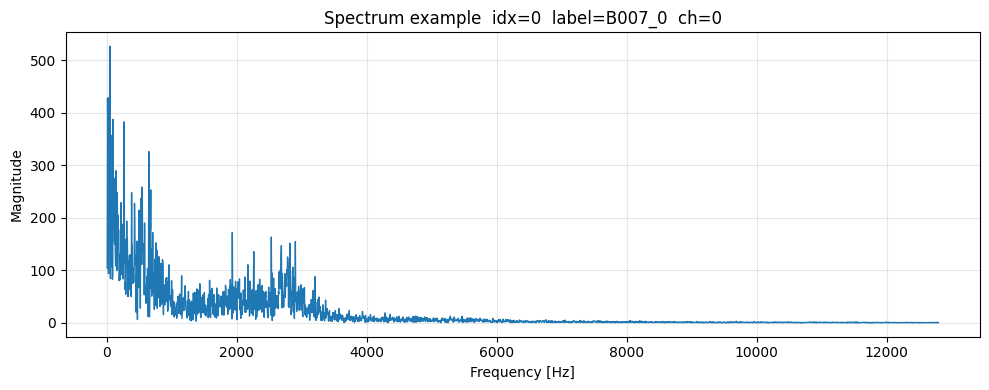

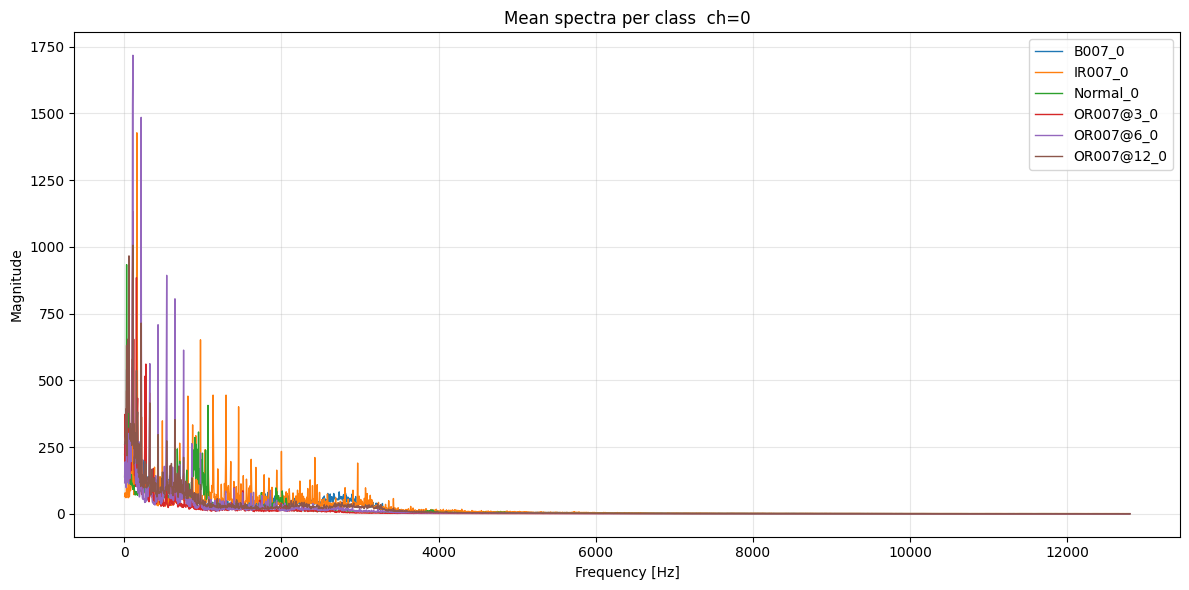

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def summarize_features(X, y, class_labels, name="dataset"):
    """
    Quick integrity report for feature tensors.
    X: [n_segments, n_bins, n_channels]
    y: [n_segments] integer ids aligned with class_labels
    """
    assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
    assert X.ndim == 3, f"X must be 3D [segments, bins, channels], got {X.shape}"
    assert y.ndim == 1, f"y must be 1D [segments], got {y.shape}"
    assert X.shape[0] == y.shape[0], "Segments count mismatch between X and y"

    # NaN or Inf check
    has_nan = np.isnan(X).any()
    has_inf = np.isinf(X).any()

    # Basic stats
    n_segments, n_bins, n_channels = X.shape
    value_min = float(np.nanmin(X))
    value_max = float(np.nanmax(X))
    value_mean = float(np.nanmean(X))

    # Label coverage
    cnt = Counter(y.tolist())
    label_rows = []
    for i, lbl in enumerate(class_labels):
        label_rows.append((lbl, cnt.get(i, 0)))

    print(f"\n[{name}] Summary")
    print(f"  Shape X: {X.shape}  y: {y.shape}")
    print(f"  Channels: {n_channels}  Bins: {n_bins}")
    print(f"  Stats  min:{value_min:.3f}  max:{value_max:.3f}  mean:{value_mean:.3f}")
    print(f"  NaN present: {has_nan}  Inf present: {has_inf}")
    print("  Samples per class:")
    for lbl, n in label_rows:
        print(f"   - {lbl}: {n}")

    # Simple per channel energy check
    energy = np.mean(np.sum(X**2, axis=1), axis=0)  # mean over segments of sum over bins per channel
    print("  Mean spectral energy per channel:", np.round(energy, 3))
    
def plot_feature_example(X, y, class_labels, fs, label=None, idx=None, channel=0):
    """
    Plot one feature vector: magnitude spectrum of a chosen segment and channel.
    If label is given chooses the first sample of that class. If idx is given uses that index.
    """
    n_segments, n_bins, n_channels = X.shape
    if channel >= n_channels:
        raise ValueError(f"channel {channel} out of range {n_channels}")

    if idx is None:
        if label is None:
            idx = 0
        else:
            cls_id = class_labels.index(label)
            where = np.where(y == cls_id)[0]
            if len(where) == 0:
                raise ValueError(f"No segments for label {label}")
            idx = int(where[0])
 
    freqs = np.fft.fftfreq(n_bins*2, d=1/fs)[:n_bins]  # consistent with window_size//2 bins
    spec = X[idx, 1:, channel]  # remove DC (first bin)
    freqs = freqs[1:]           # remove DC frequency

    plt.figure(figsize=(10,4))
    plt.plot(freqs, spec, lw=1)
    ttl_label = class_labels[y[idx]] if 0 <= y[idx] < len(class_labels) else f"id {y[idx]}"
    plt.title(f"Spectrum example  idx={idx}  label={ttl_label}  ch={channel}")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_class_mean_spectra(X, y, class_labels, fs, channel=0):
    """
    Plot mean spectrum per class for a chosen channel for a quick separability check.
    """
    n_segments, n_bins, n_channels = X.shape
    if channel >= n_channels:
        raise ValueError(f"channel {channel} out of range {n_channels}")
    freqs = np.fft.fftfreq(n_bins*2, d=1/fs)[:n_bins]
    freqs = freqs[1:]  # remove DC frequency

    plt.figure(figsize=(12,6))
    for cid, lbl in enumerate(class_labels):
        idxs = np.where(y == cid)[0]
        if len(idxs) == 0:
            continue
        mean_spec = X[idxs, 1:, channel].mean(axis=0)
        plt.plot(freqs, mean_spec, lw=1, label=lbl)
    plt.title(f"Mean spectra per class  ch={channel}")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# KAIST
summarize_features(X_kaist, y_kaist, class_labels_kaist, name="KAIST")
plot_feature_example(X_kaist, y_kaist, class_labels_kaist, fs=sampling_rate_kaist, label=class_labels_kaist[0], channel=0)
plot_class_mean_spectra(X_kaist, y_kaist, class_labels_kaist, fs=sampling_rate_kaist, channel=0)

# CWRU
summarize_features(X_cwru, y_cwru, class_labels_cwru, name="CWRU")
plot_feature_example(X_cwru, y_cwru, class_labels_cwru, fs=target_sampling_rate_cwru, label=class_labels_cwru[0], channel=0)
plot_class_mean_spectra(X_cwru, y_cwru, class_labels_cwru, fs=target_sampling_rate_cwru, channel=0)


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft

def plot_signal_examples(data_dict, class_labels, sampling_rate, window_size):
    """
    Enhanced function to plot signal examples with proper feature extraction pipeline.
    
    This function demonstrates the complete signal processing pipeline used in extract_features:
    1. Signal segmentation
    2. Z-score normalization per segment
    3. Hilbert transform for vibration sensors (channels 0, 3)
    4. FFT transformation
    5. Comparison of raw vs processed signals
    """
    
    # Calculate frequency array for FFT plots
    freqs = np.fft.fftfreq(window_size, d=1/sampling_rate)[:window_size // 2]
    
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 14))
    
    # Randomly select a class and sensor
    label = class_labels[np.random.randint(0, len(class_labels))]
    data = data_dict[label]
    num_samples, num_sensors = data.shape
    
    # Select a vibration sensor (0 or 3)
    sensor_idx = np.random.choice([0,1])
    sensor_data = data[:, sensor_idx]
    
    # Select a random segment
    num_segments = num_samples // window_size
    random_idx = np.random.randint(0, num_segments)
    segment = sensor_data[random_idx * window_size:(random_idx + 1) * window_size]
    
    # Apply the same processing pipeline as extract_features
    # 1. Z-score normalization
    segment_mean = np.mean(segment)
    segment_std = np.std(segment)
    if segment_std == 0:
        segment_std = 1e-8
    segment_normalized = (segment - segment_mean) / segment_std
    
    # 2. Hilbert transform (for vibration sensors)
    segment_hilbert = np.abs(hilbert(segment_normalized))
    
    # 3. FFT transformation
    fft_raw = np.abs(fft(segment))[:window_size // 2]
    fft_processed = np.abs(fft(segment_hilbert))[:window_size // 2]
    fft_processed[0] = 0  # Remove DC component for clarity"
    
    # Plotting
    # Raw Signal
    axes[0].plot(segment, label="Raw Signal", linewidth=1)
    axes[0].set_title(f"Raw Signal - {label} (Sensor {sensor_idx})")
    axes[0].set_xlabel("Sample")
    axes[0].set_ylabel("Amplitude")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Normalized Signal
    axes[1].plot(segment_normalized, label="Normalized", color='orange', linewidth=1)
    axes[1].set_title("Z-score Normalized Signal")
    axes[1].set_xlabel("Sample")
    axes[1].set_ylabel("Normalized Amplitude")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Hilbert Transform Envelope
    axes[2].plot(segment_hilbert, label="Hilbert Envelope", color='red', linewidth=1)
    axes[2].set_title("Hilbert Transform Envelope")
    axes[2].set_xlabel("Sample")
    axes[2].set_ylabel("Envelope Amplitude")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # FFT Comparison
    axes[3].plot(freqs, fft_raw, label="Raw FFT", alpha=0.7, linewidth=1)
    axes[3].plot(freqs, fft_processed, label="Processed FFT", alpha=0.7, linewidth=1)
    axes[3].set_title("Frequency Spectrum Comparison")
    axes[3].set_xlabel("Frequency (Hz)")
    axes[3].set_ylabel("Magnitude")
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Plot KAIST Feature Extraction

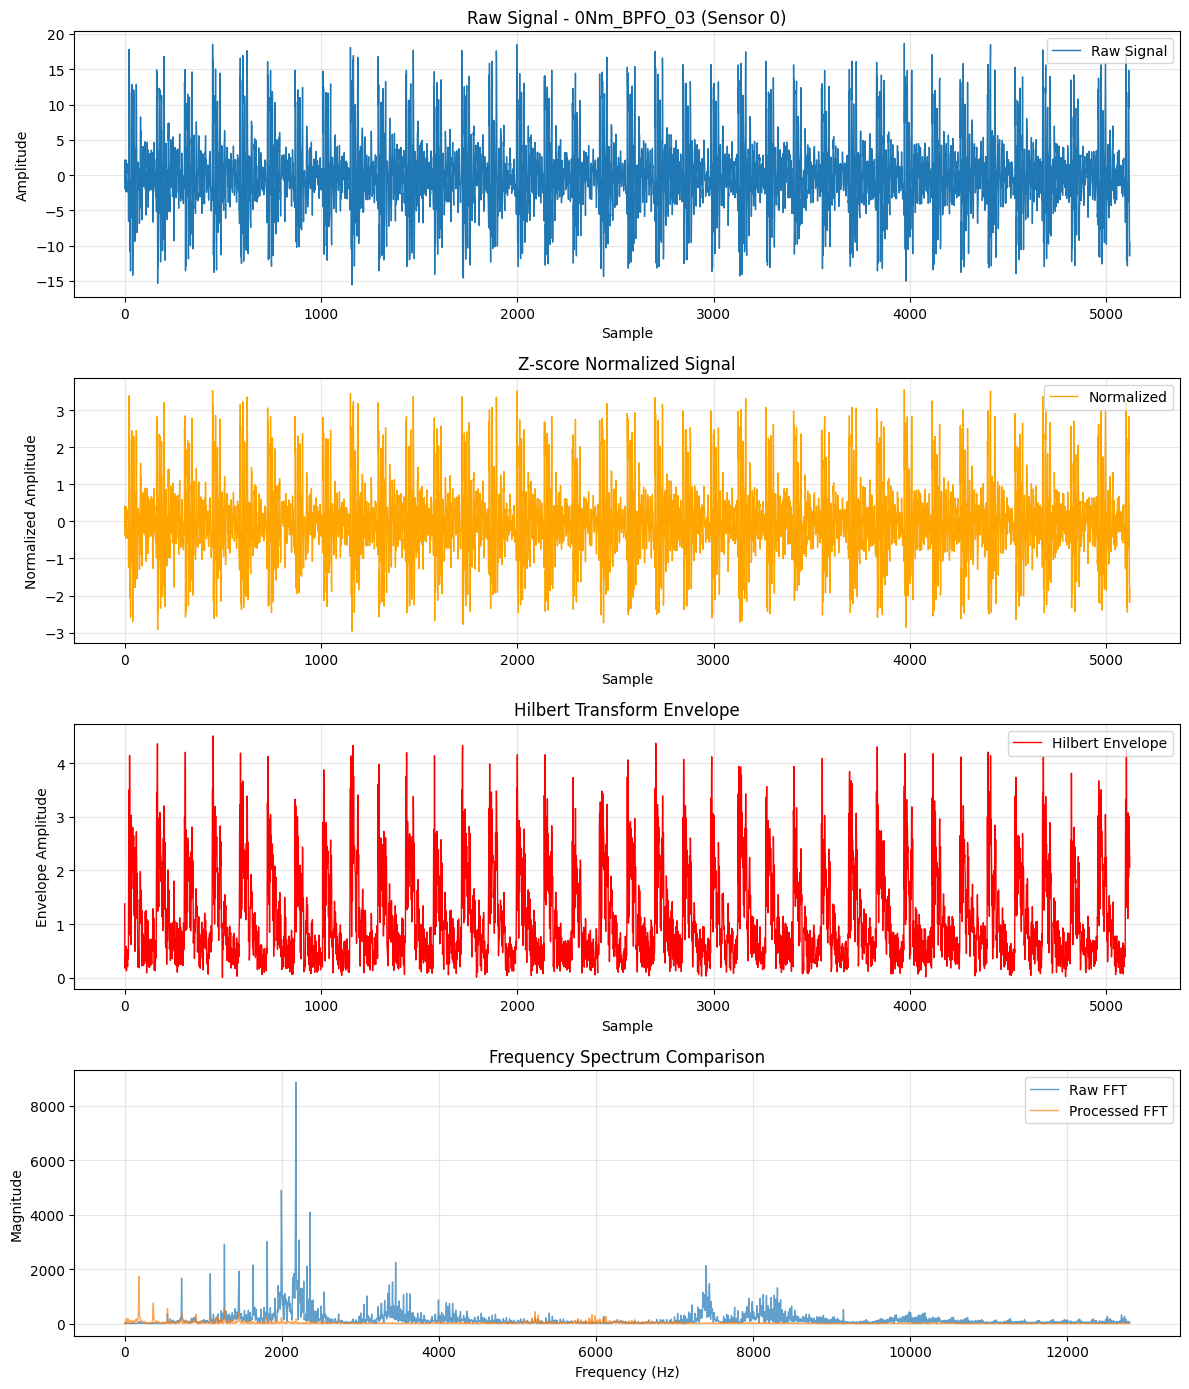

In [10]:
plot_signal_examples(vibration_data_kaist, class_labels_kaist, sampling_rate_kaist, window_size=5120)

Plot CWRU Feature Extraction

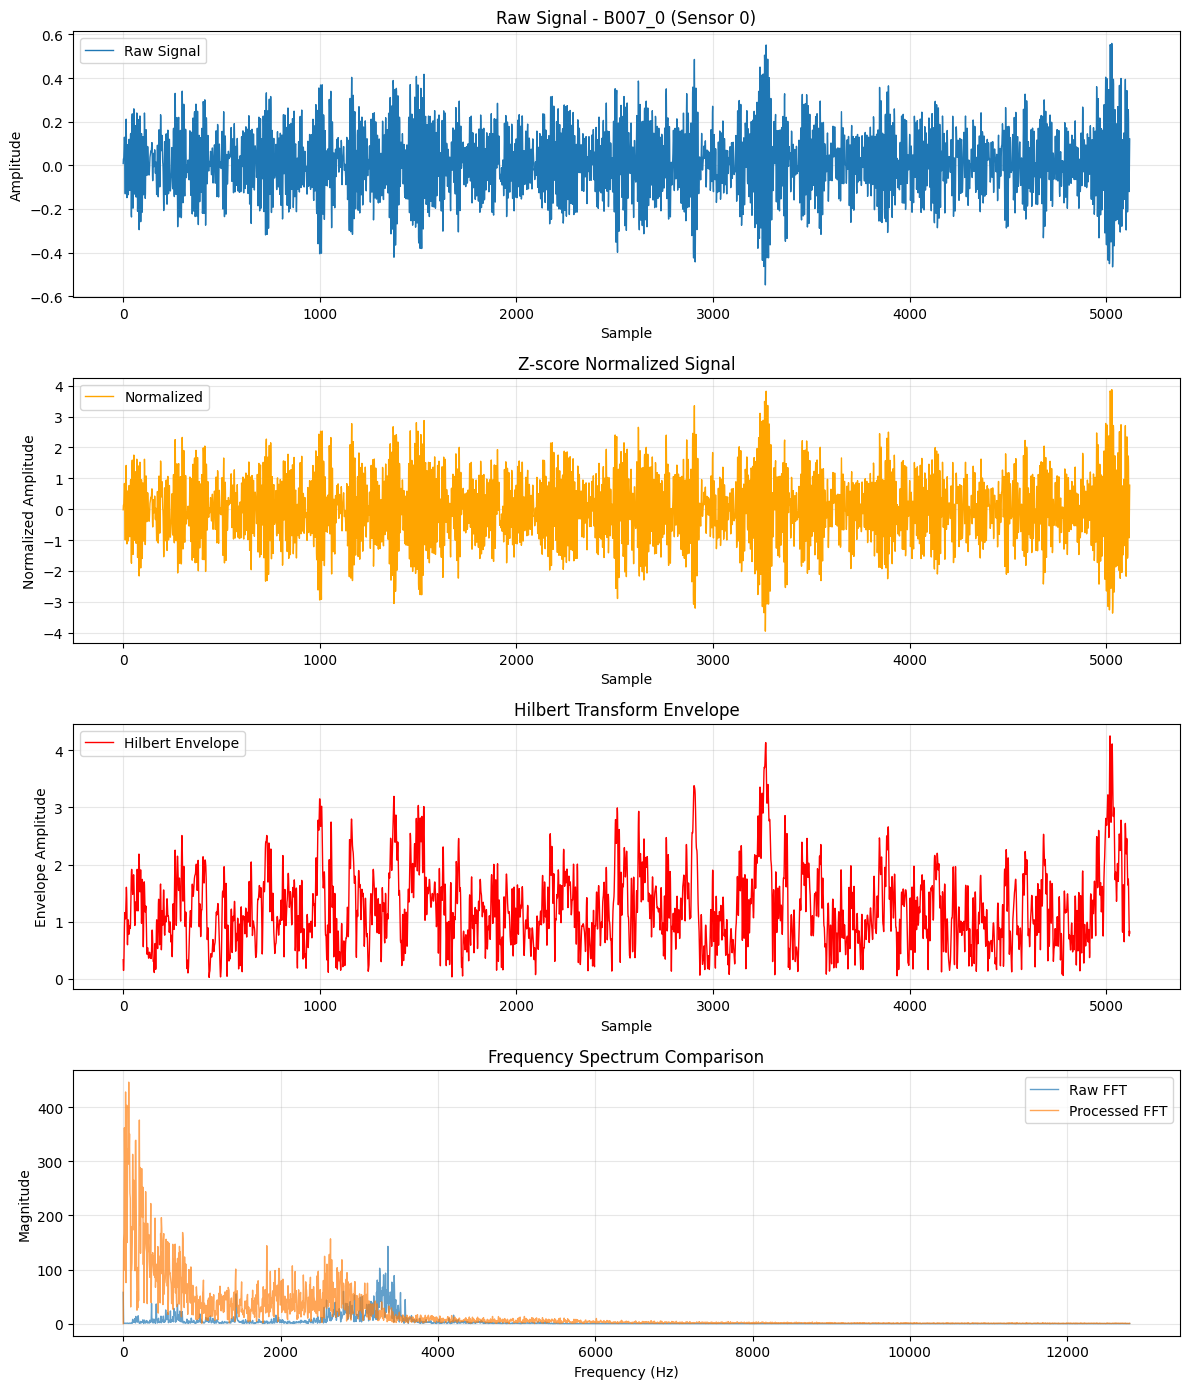

In [11]:
plot_signal_examples(vibration_data_cwru, class_labels_cwru, target_sampling_rate_cwru, window_size=5120)

## Remap Labels

In [12]:
# Unified labels
unified_labels = ['Normal', 'BPFI', 'BPFO']

# Mapping KAIST → unified
kaist_map = {
    '0Nm_Normal': 'Normal',
    '0Nm_BPFI_03': 'BPFI',
    '0Nm_BPFO_03': 'BPFO',
    # the following do not exist in unified, mark as None
    '0Nm_Misalign_01': None,
    '0Nm_Unbalance_0583mg': None
}

# Mapping CWRU → unified
cwru_map = {
    'Normal_0': 'Normal',
    'IR007_0': 'BPFI',
    'B007_0': 'BPFI',         # inner race faults (IR/B) → BPFI
    'OR007@3_0': 'BPFO',
    'OR007@6_0': 'BPFO',
    'OR007@12_0': 'BPFO'
}

# Function to remap dictionaries
def remap_data_dict(data_dict, label_map):
    new_dict = {}
    for old_label, samples in data_dict.items():
        new_label = label_map.get(old_label, None)
        if new_label is None:
            continue  # drop classes not in unified_labels
        if new_label not in new_dict:
            new_dict[new_label] = []
        new_dict[new_label].extend(samples)
    return new_dict

# Example usage
# kaist_dict = {'0Nm_Normal': [...], '0Nm_BPFI_03': [...], ...}
# cwru_dict = {'IR007_0': [...], 'Normal_0': [...], ...}

vibration_data_kaist_unified = remap_data_dict(vibration_data_kaist, kaist_map)
vibration_data_cwru_unified = remap_data_dict(vibration_data_cwru, cwru_map)


# Model Definition

## Build Backbone model (KAIST)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D, Dense

# Define input shape
input_shape = (2560, 1)  # (features, channels)

# Build the model
def build_model(input_shape, num_classes=5):
    model = Sequential([
        # Conv Block 1
        Conv1D(filters=32, kernel_size=33, strides=6, padding='same', input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=3, strides=3, padding='same'),
        
        # Conv Block 2
        Conv1D(filters=64, kernel_size=9, strides=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=3, strides=3, padding='same'),
        
        # Conv Block 3
        Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2, strides=2, padding='same'),

        # Adaptive Pooling (Global Average Pooling for output size 128)
        GlobalAveragePooling1D(),  # Adaptive pooling to fixed size 128

        # Fully Connected Layer
        Dense(100, activation='relu'),

        # Output Layer (Change units and activation based on your task)
        Dense(num_classes, activation='softmax')  # Adjust for number of classes
    ])
    
    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1) Build KAIST features with one channel
X, y_int, used_ch, meta = X_kaist, y_kaist, ch_kaist, meta_kaist

X = X.astype("float32")                 # [N, 2560, 1]
y = tf.keras.utils.to_categorical(y_int, num_classes=len(class_labels_kaist0))


# 2) Define input shape directly from X
input_shape = (X.shape[1], X.shape[2])  # (2560, 1)

# 3) Build and train as before
model = build_model(input_shape, num_classes=len(class_labels_kaist0))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (tr, te) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}/5")
    X_train, X_test = X[tr], X[te]
    Y_train, Y_test = y[tr], y[te]

    m = build_model(input_shape, num_classes=len(class_labels_kaist0))
    m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
        ModelCheckpoint(f"model_fold_{fold}.h5", monitor="val_accuracy", save_best_only=True)
    ]
    m.fit(X_train, Y_train, epochs=100, batch_size=32,
          validation_data=(X_test, Y_test), callbacks=callbacks, verbose=1)
